<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Part 1 - Bus arrival delays regression modeling**

In [15]:
import pandas as pd

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)

# df = pd.read_csv('Exercise2BusData.csv')
df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


Let's try to check **different approaches**, one that exploits the large database we have with **all the 2179 entries**, and others that only use a **limited number** of random entries to check how large of a difference we get.


In [16]:
#Remove columns that are no longer needed
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)

I'll write a short loop that runs the linear regression with the different number of rows we select.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

metrics = pd.DataFrame(columns=['method','Number of rows', 'MAE', 'MSE', 'R2'])

for i, num in enumerate([50, 200, 500, 2179]): #select the different number entries to evaluate
  df_sample = df.sample(n=num, random_state=42) #creating the sample df with the random entries

  x = df_sample.drop(['Arrival_delay'], axis=1) # selecting the independent variables
  y = df_sample['Arrival_delay'] #selecting the dependent variable
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #train and test pools

  # Create a Linear Regression model
  model = LinearRegression()
  model.fit(X_train, y_train)# Fit the model to the training data
  y_pred = model.predict(X_test)# Predict the test data with the fitted model

  #evaluation of the metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  #Storing the values
  metrics.loc[i]=['Lin reg',num,mae,mse,r2]

**Let's now try and use XGBoost**

In [18]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.02, 0.5],
    'max_depth': [2, 3, 5]
}

# creating an XGBoost Regressor model
xgb_model = xgb.XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

# Use the full dataframe
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

# train and testing
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train_full, y_train_full)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# prediction
y_pred_xgb = best_xgb_model.predict(X_test_full)

# Evaluate the best model
mae_xgb = mean_absolute_error(y_test_full, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_full, y_pred_xgb)
r2_xgb = r2_score(y_test_full, y_pred_xgb)

metrics.loc[len(metrics)]=['XGBoost', len(x), mae_xgb, mse_xgb, r2_xgb]

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}


###Comparison of the different methods

In [19]:
metrics

,method,Number of rows,MAE,MSE,R2
0,Lin reg,50,15.925672,526.951283,0.968390
1,Lin reg,200,9.852195,171.089590,0.990398
2,Lin reg,500,10.409570,208.023546,0.995662
3,Lin reg,2179,9.339559,150.404587,0.996024
4,XGBoost,2179,10.766816,214.635498,0.992802


The linear regression and XGboost at the same sample size perform quite similarly in terms of error metrics. Let's see a visualization of how the two perform in a *predicted v. actual* plot.

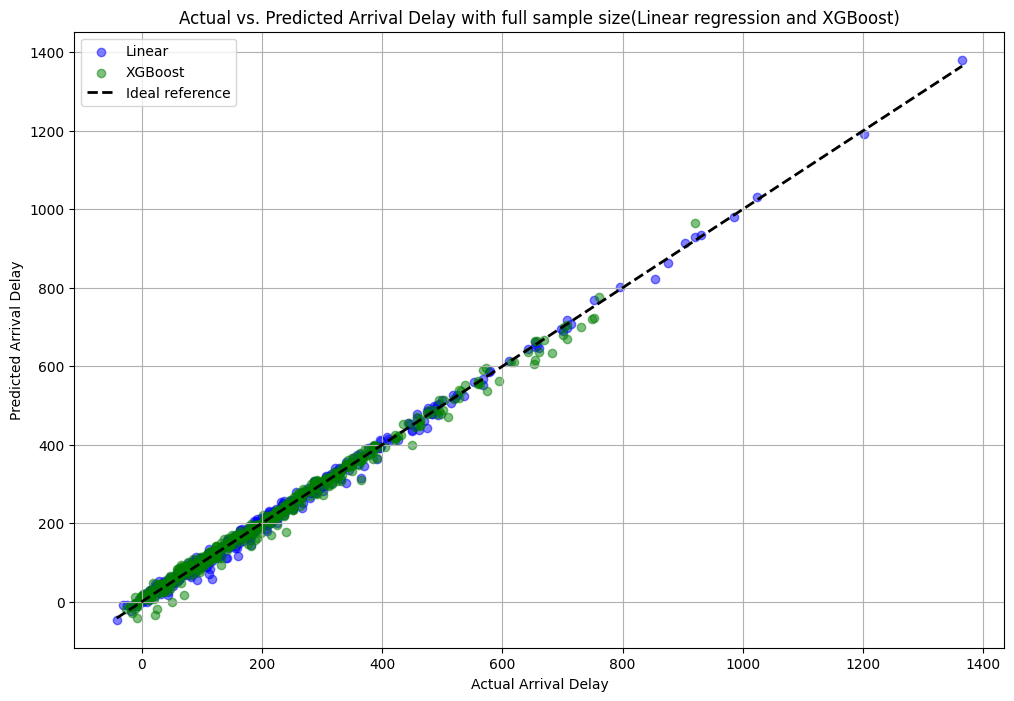

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot for Linear regression and XGBoost
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Linear')
plt.scatter(y_test_full, y_pred_xgb, color='green', alpha=0.5, label='XGBoost')

# Add a diagonal line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal reference')

plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Actual vs. Predicted Arrival Delay with full sample size(Linear regression and XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

**The following metrics show the importance of the the different parameters in the estimation of Arrival delays for both methods.**

In [21]:
importance = pd.Series(model.coef_, index=x.columns)
print(importance.sort_values(ascending=False))

Dwell_time               1.011308
Upstream_stop_delay      1.002616
Recurrent_delay          0.495398
Scheduled_travel_time   -0.487134
dtype: float64


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

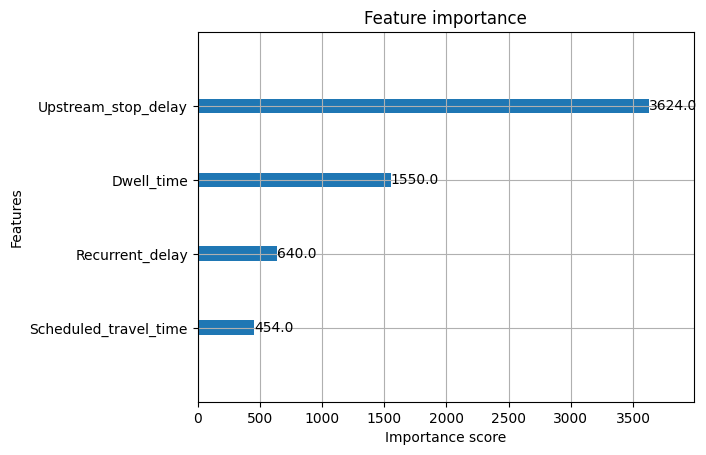

In [22]:
xgb.plot_importance(best_xgb_model, importance_type='weight')

So we can see that even with tuned hyperparameters the metrics show that **XGboost** performs in a **comparable** way to a simple **regression**. Furthermore the two methods show slightly different metrics, in the table above we see the **coefficients** of each feature in the linear equation. In the bar chart below we see the amount of **trees** in which each feature is used to split the data

##**Part 2 - Bike sharing demand prediction**

In [23]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BikeSharing.csv'
df_2 = pd.read_csv(url)

In [24]:
df_2.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [25]:
# define features and target
X = df_2.drop(['instant', 'dteday', 'casual', 'registered', 'cnt'], axis=1)
y = df_2['cnt']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.preprocessing import StandardScaler

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Let's try some gridsearch on support vector regression**

In [27]:
from sklearn.svm import SVR

# Define a parameter grid for hyperparameter tuning (I chose the ones already picked in the example)
param_grid = {
    'kernel': ['linear',  'rbf'],
    'C': [ 1, 10],
    'epsilon': [ 1, 10]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, verbose=2)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................C=1, epsilon=1, kernel=linear; total time=   6.8s
[CV] END ......................C=1, epsilon=1, kernel=linear; total time=   7.6s
[CV] END ......................C=1, epsilon=1, kernel=linear; total time=   8.5s
[CV] END ......................C=1, epsilon=1, kernel=linear; total time=   6.3s
[CV] END ......................C=1, epsilon=1, kernel=linear; total time=   9.0s
[CV] END .........................C=1, epsilon=1, kernel=rbf; total time=   9.3s
[CV] END .........................C=1, epsilon=1, kernel=rbf; total time=   9.9s
[CV] END .........................C=1, epsilon=1, kernel=rbf; total time=  10.5s
[CV] END .........................C=1, epsilon=1, kernel=rbf; total time=  10.4s
[CV] END .........................C=1, epsilon=1, kernel=rbf; total time=   9.1s
[CV] END .....................C=1, epsilon=10, kernel=linear; total time=   7.2s
[CV] END .....................C=1, epsilon=10, ke

In [28]:
# Create an SVR model with the best parameters from the grid search
best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])
best_svr.fit(X_train, y_train)

SVR(C=10, epsilon=10)

In [29]:
y_pred = best_svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

**If we try with XGBoost then we can compare the two**

In [74]:
# Create an XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(random_state=42, learning_rate=0.1, n_estimators=1000, max_depth=6)
# Fit the model to the scaled training data
xgb_reg.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_xgb = xgb_reg.predict(X_test_scaled)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [75]:
import pandas as pd

# Create a dictionary with the metrics for each model
metrics_data = {
    'Model': ['SVR', 'XGBoost'],
    'MAE': [mae, mae_xgb],
    'MSE': [mse, mse_xgb],
    'R2': [r2, r2_xgb]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)

,Model,MAE,MSE,R2
0,SVR,77.931876,15893.325604,0.498086
1,XGBoost,23.514727,1480.382935,0.953249


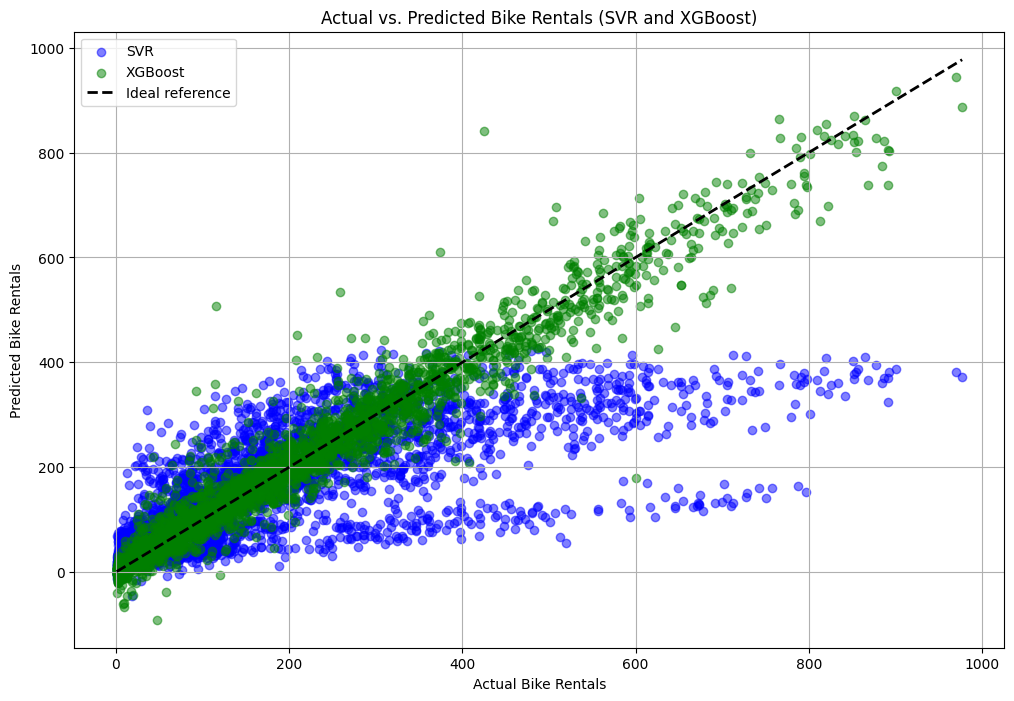

In [76]:
plt.figure(figsize=(12, 8))

# Plot for SVR and XGBoost
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='SVR')
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.5, label='XGBoost')

# Add a diagonal line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal reference')

plt.xlabel('Actual Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.title('Actual vs. Predicted Bike Rentals (SVR and XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

**In this case we can see that the XGBoost regressor has far better performance both in terms of metrics and time taken to execute, despite not having finetuned the hyperparameters.**

